- JIT?? https://pytorch.org/blog/optimizing-cuda-rnn-with-torchscript/
- faster datasetdataloader
- c++?
- real data?
- https://gist.github.com/ZijiaLewisLu/eabdca955110833c0ce984d34eb7ff39



In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
import os
#os.environ["OMP_NUM_THREADS"] = "1"
#os.environ["MKL_NUM_THREADS"] = "2"

<IPython.core.display.Javascript object>


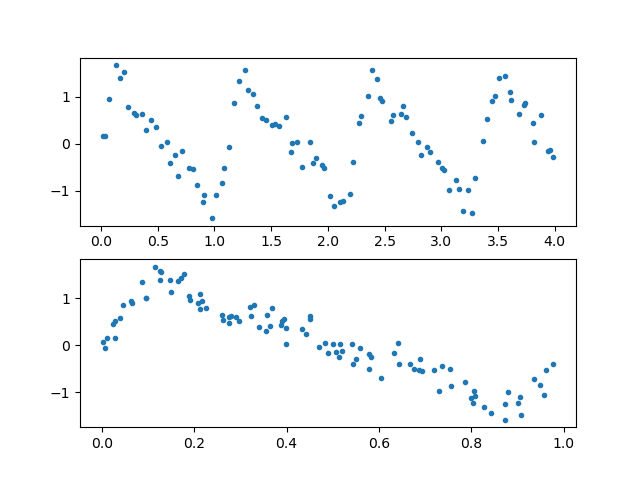

In [2]:
t = np.linspace(0, 4, num=100, dtype=np.float32)
t += np.random.randn(len(t))*0.01
t = np.sort(t)
P = 1.1234
m = np.sin(2.0*np.pi*t/P) + 0.5*np.sin(2.0*np.pi*2*t/P)  + 0.25*np.sin(2.0*np.pi*3*t/P)
m += np.random.randn(len(m))*0.2
fig, ax = plt.subplots(2)
ax[0].plot(t, m, '.')
ax[1].plot(np.mod(t, P)/P, m, '.')

In [42]:
import torch
import torch.nn as nn

class PeriodFinder(nn.Module):
    def __init__(self):
        super(type(self), self).__init__()
        self.conv1 = nn.Conv1d(1, 8, 5, stride=1)
        self.conv2 = nn.Conv1d(8, 16, 5, stride=1)
        self.conv3 = nn.Conv1d(16, 16, 5, stride=1)
        self.apool = nn.AdaptiveAvgPool1d(1)
        self.linear1 = nn.Linear(16, 1)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        h = self.activation(self.conv1(x))
        h = self.activation(self.conv2(h))
        h = self.activation(self.conv3(h))
        h = self.apool(h)
        return self.linear1(h.view(-1, self.linear1.weight.shape[1]))    


from torch.utils.data import Dataset, DataLoader

class lc_folder(Dataset):
    
    def __init__(self, mjd, mag):
        self.mjd =  torch.from_numpy(mjd.astype('float32'))
        self.mag =  torch.from_numpy(mag.astype('float32')).unsqueeze(0)
        self.freq = torch.arange(1e-4, 5, step=1e-4)
        
    def __getitem__(self, idx):
        phi = torch.remainder(self.mjd, 1/self.freq[idx])        
        return self.mag[:, torch.argsort(phi)]
    
    def __len__(self):
        return self.freq.shape[0]
    
class lc_trainer(Dataset):
    
    def __init__(self, mjd, mag, P):
        self.mjd =  torch.from_numpy(mjd.astype('float32'))
        self.mag =  torch.from_numpy(mag.astype('float32')).unsqueeze(0)
        self.P = P
        
    def __getitem__(self, idx):
        label = 0.
        if torch.rand(1) > 0.5:
            label = 1.
            phi = torch.remainder(self.mjd, self.P)
        else:
            phi = torch.remainder(self.mjd, 5*torch.rand(1)+1e-4)
        
        return self.mag[:, torch.argsort(phi)], label
    
    def __len__(self):
        return 1

data_train = lc_trainer(t, m, P)
data_eval = lc_folder(t, m)

with torch.jit.optimized_execution(True):
    my_script_module = torch.jit.script(PeriodFinder())

torch.set_num_threads(1)

In [48]:
model = PeriodFinder()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1000):
    epoch_loss = 0.0
    for folded_data, label in DataLoader(data_train, batch_size=1):
        optimizer.zero_grad()
        yhat = model(folded_data)
        loss = criterion(yhat.squeeze(0), label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(epoch_loss)

0.7550287693738937
0.6471892595291138
0.7425171509385109
0.6504701972007751
0.6501730680465698
0.7407460361719131
0.6476830840110779
0.6458765864372253
0.7447012141346931
0.6416558027267456
0.747395746409893
0.6387588977813721
0.6369640827178955
0.6341437697410583
0.6304583549499512
0.6260440349578857
0.7627610415220261
0.7688424289226532
0.7706981599330902
0.6160013675689697
0.6147904992103577
0.6126389503479004
0.7764833271503448
0.77330182492733
0.608092725276947
0.7769461870193481
0.7783228754997253
0.777746319770813
0.7767764180898666
0.6143742799758911
0.7626778781414032
0.6192014813423157
0.7591385692358017
0.6230064630508423
0.6239209771156311
0.6234859228134155
0.7591623663902283
0.6216556429862976
0.6202936172485352
0.7554280981421471
0.7562577128410339
0.7629599273204803
0.618911862373352
0.7612148225307465
0.74959347397089
0.6229028105735779
0.6239925622940063
0.75312440097332
0.6249080896377563
0.6247168779373169
0.7524481117725372
0.6233903169631958
0.7477672398090363
0.6

0.014109382405877113
0.06547868996858597
2.2926309183239937
0.09737180173397064
0.12768302857875824
0.15752768516540527
0.0032206117175519466
2.3841855067985307e-07
9.536738616588991e-07
0.0020828000269830227
0.28083643317222595
2.3841855067985307e-07
0.2781487703323364
0.2542599141597748
0.21710845828056335
0.000854961050208658
5.23315102327615e-05
0.00040749352774582803
7.152555099310121e-07
0.09771803766489029
0.0062958477064967155
0.07852999120950699
0.07101642340421677
0.009223825298249722
0.00014780859055463225
0.05500473454594612
0.05112751945853233
0.04761095345020294
0.04442800208926201
0.04154118895530701
0.004472016356885433
0.036781132221221924
1.5139465176616795e-05
0.03314320370554924
2.8729025871143676e-05
0.030237458646297455
0.02897389978170395
0.0277848020195961
0.010646214708685875
0.025765594094991684
0.01590646803379059
0.034410033375024796
0.0009909725049510598
4.7205765440594405e-05
0.022870458662509918
0.02245919778943062
0.0220295749604702
0.03757457807660103
0

In [27]:
torch.rand(1) > 0.5

tensor([False])

In [53]:
#%%timeit -r3 -n1
#%%prun
output = torch.tensor([])
with torch.no_grad():
    for folded_data in DataLoader(data_eval, batch_size=512, num_workers=1):
        output = torch.cat((output, model(folded_data)))

<IPython.core.display.Javascript object>


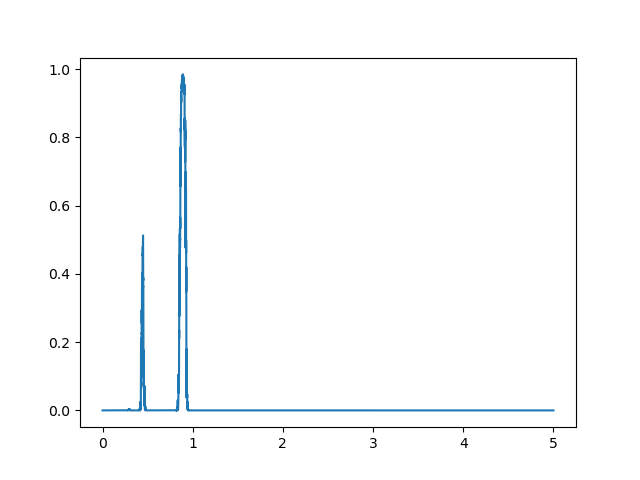

In [63]:
fig, ax = plt.subplots()
ax.plot(data_eval.freq.numpy(), nn.Sigmoid()(output).numpy()[:, 0])

In [18]:
%%timeit -r3 -n1
import P4J
per = P4J.periodogram(method="MHAOV")
per.set_data(t, m, m)
per.frequency_grid_evaluation(fmin=0, fmax=5., fresolution=1e-4)

180 ms ± 2.85 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
